In [1]:
!wget https://raw.githubusercontent.com/wooorm/dictionaries/master/dictionaries/es/index.dic
!wget https://raw.githubusercontent.com/wooorm/dictionaries/master/dictionaries/es/index.aff
!mv index.dic es.dic
!mv index.aff es.aff

--2022-03-10 19:06:30--  https://raw.githubusercontent.com/wooorm/dictionaries/master/dictionaries/es/index.dic
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702340 (686K) [text/plain]
Saving to: ‘index.dic’

index.dic           100%[===================>] 685.88K  --.-KB/s    in 0.06s   

2022-03-10 19:06:30 (11.1 MB/s) - ‘index.dic’ saved [702340/702340]

--2022-03-10 19:06:30--  https://raw.githubusercontent.com/wooorm/dictionaries/master/dictionaries/es/index.aff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167135 (163K) [

In [4]:
!mkdir content

In [1]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/callejonm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import hunspell # Nos ayudará con los diccionarios en español
# Buscar diccionarios en carpeta de instalacion
# Más diccionarios de idiomas disponibles en: https://github.com/wooorm/dictionaries/tree/master/dictionaries
diccionario = hunspell.HunSpell(
    '/home/callejonm/Documents/NLP-sentiment/content/es.dic',
    '/home/callejonm/Documents/NLP-sentiment/content/es.aff')


from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [3]:
def corregir_palabras(corrector, palabras, agregarPrimero=[]):   
    #codificacion = corrector.get_dic_encoding()   # obtenemos la codificacion para usarla luego

    # agregamos las palabras aleatorias al diccionario
    for palabra in agregarPrimero:
        corrector.add(palabra)

    # autocorreccion de palabras
    corregida = []
    for p in palabras:
        ok = corrector.spell(p)   # verificamos ortografia
        if not ok:
            sugerencias = corrector.suggest(p)
            if len(sugerencias) > 0:  # hay sugerencias
                # tomamos la  mejor sugerencia(decodificada a string)
                mejor_sugerencia = sugerencias[0]   
                corregida.append(mejor_sugerencia)
            else:
                corregida.append(p)  # no hay ninguna sugerecia para la palabra
        else:
            corregida.append(p)   # esta palabra esta corregida

    return corregida


def corregir_oracion(corrector,string):
    oracion_fixed=''
    if len(string)>0:
        oracion_dirty=string.split()
        oracion_fixed=corregir_palabras(corrector, oracion_dirty,[''])
        oracion_fixed=' '.join(oracion_fixed)
    else:
      print('error')
    return oracion_fixed

In [4]:
def preprocess(ReviewText):
    ReviewText = ReviewText.replace('\t', ' ')
    ReviewText = ReviewText.replace('\r', ' ')
    ReviewText = ReviewText.replace('\n', ' ')
    ReviewText = ReviewText.replace('\x0c', ' ')
    ReviewText = re.sub("6\d\d  Ricardo López Aranda", ' ', ReviewText)
    ReviewText = re.sub("Ricardo López Aranda  6\d\d", ' ', ReviewText)
    ReviewText = re.sub("Los extraños amantes  6\d\d", ' ', ReviewText)
    ReviewText = re.sub("6\d\d  Los extraños amantes", ' ', ReviewText)
    ReviewText = re.sub("\(([^\)]+)\)", ' ', ReviewText)
    return (ReviewText)    

In [6]:
import deepl
import os

translator = deepl.Translator(os.getenv("DEEPL_AUTH_KEY"))

In [7]:
def translate(text):
    return translator.translate_text(text, target_lang = "EN-US")

In [8]:
def spell_checker_spanish():
    try:
        df.drop('Código', axis=1, inplace=True) # No viene al caso
        df.drop('Nombre', axis=1, inplace=True) # Anonimos
        df.drop('Número', axis=1, inplace=True) # No viene al caso
    except:
        pass

    df['polarity']=0
    df['neg']=0
    df['neu']=0
    df['pos']=0
    df['translated']=0

    for i in range(len(df)):#len(df)
        try:
            temp=df['Relato'][i]
            fixed=corregir_oracion(diccionario,temp)
            #fixed=preprocess(str(fixed))
            df.loc[i,'RelatoFixed']=fixed
            print(i,end=' - ')

        except Exception as e:
            print('Error {}:{}'.format(i,e))

In [9]:
import pdftotext as pdf2txt
from itertools import islice
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [10]:
with open("content/los-extranos-amantes--0.pdf", 'rb') as pdf:
    txt = pdf2txt.PDF(pdf)

In [11]:
text = "\n\n".join(txt)

In [12]:
text_processed = preprocess(text)

In [14]:
matches = re.findall("(?:(ÉL)\.(.*?)((?=ELLA\.)|(?=ÉL\.)|(?=ELLA Y ÉL\.))|(ELLA)\.(.*?)((?=ÉL\.)|(?=ELLA\.)|(?=ELLA Y ÉL\.))|(ELLA Y ÉL)\.(.*?)(?=ÉL\.)|(?=ELLA\.))", str(text_processed))
data = [tuple(filter(None, x)) for x in matches]

In [15]:
df = pd.DataFrame(data)

In [16]:
df.columns = ("Personaje", "Texto")

In [17]:
df

,Personaje,Texto
0,ÉL,¡Hooop...!
1,ELLA,¡Hooop!...
2,ELLA Y ÉL,¡Hooop!... Bugi-Bugi El corazón el corazó...
3,ÉL,Señoras y señores: de ese cofre de los su...
4,ÉL,"Dolorosas. ¿Puedo, si no es engorro? Yo soy..."
...,...,...
560,ELLA,Tengo que irme. He quedado con otro. O por me...
561,ÉL,"No. Ahora que te he conocido, no lo permitiré..."
562,ELLA,"Amor mío, aún no me has dicho cómo te llamas."
563,ÉL,"Javier, ¿y tú amor mío?"


In [31]:
df['text_len'] = df['Texto'].astype(str).apply(len)
df['word_count'] = df['Texto'].apply(lambda x: len(str(x).split()))

In [37]:
df.to_pickle("content/losamantesnoseque.pk")
df

,Personaje,Texto,text_len,word_count,TranslatedText
0,ÉL,¡Hooop...!,14,1,¡Hooop...!
1,ELLA,¡Hooop!...,16,1,¡Hooop!...
2,ELLA Y ÉL,¡Hooop!... Bugi-Bugi El corazón el corazó...,666,117,Hooop!... Bugi-Bugi The heart the heart o...
3,ÉL,Señoras y señores: de ese cofre de los su...,924,151,Ladies and gentlemen: from that chest of dr...
4,ÉL,"Dolorosas. ¿Puedo, si no es engorro? Yo soy...",100,19,"Painful. May I, if it's not too much trouble?..."
...,...,...,...,...,...
560,ELLA,Tengo que irme. He quedado con otro. O por me...,162,31,I have to go. I'm meeting someone else. Or ra...
561,ÉL,"No. Ahora que te he conocido, no lo permitiré...",103,17,"No. Now that I have met you, I will not allow..."
562,ELLA,"Amor mío, aún no me has dicho cómo te llamas.",47,10,"My love, you still haven't told me your name."
563,ÉL,"Javier, ¿y tú amor mío?",25,5,"Javier, and you my love?"


In [38]:
def get_polarity(dataframe, label):
  for i in tqdm(range(len(dataframe))):#len(df)
      try:
          temp=dataframe[label][i]  
          
          # translation= translate_client.translate(temp,target_language='en',source_language='es') # Already translated
          # translation=translation['translatedText'] # Already translated
          p=sid.polarity_scores(str(temp))['compound']
          neg=sid.polarity_scores(str(temp))['neg']
          neu=sid.polarity_scores(str(temp))['neu']
          pos=sid.polarity_scores(str(temp))['pos']
          dataframe.loc[i,'polarity']=p
          dataframe.loc[i,'neg']=neg
          dataframe.loc[i,'neu']=neu
          dataframe.loc[i,'pos']=pos
          #df.loc[i,'translated']=str(translation) # Already translated
          #print(i,end=' - ')
          #sleep(0.1+random.random()/2) # Already translated
      except Exception as e:
          print('Error {}:{}'.format(i,e))

In [40]:
get_polarity(df, 'TranslatedText')

  0%|          | 0/565 [00:00<?, ?it/s]

In [43]:
try:
  cl = df.loc[df['polarity'] ==1, ['TranslatedText']].sample(5).values
  for c in cl:
    print(c[0][:15])
except:
  pass

In [44]:
try:
  cl = df.loc[df['polarity'] ==0, ['TranslatedText']].sample(5).values
  for c in cl:
    print(c[0][:15])
except:
  pass

   Who is your 
 What happens i
   ¡Ay! Suéltem
 On a flight.  
 What?


In [46]:
df.to_pickle("content/losamantesnosequepolarity.pk")

In [47]:
%matplotlib qt
df.reset_index().plot(x = 'index', y = 'polarity', kind = 'scatter',)

<AxesSubplot:xlabel='index', ylabel='polarity'>

virtual void QEventDispatcherUNIX::registerSocketNotifier(QSocketNotifier*): Multiple socket notifiers for same socket 11 and type Read


In [48]:
df.columns[3]

'word_count'

In [68]:

cond1 = df['Personaje']=='ÉL' 
cond2 = df['Personaje']=='ELLA'
cond3 = abs(df['polarity'])>1e-6

HIM = df.loc[cond1 * cond3]
HER = df.loc[cond2 * cond3]

Text(0.5, 1.0, 'Polarity study of "Los extraños amantes" by using ntlk sentiment analysis and hunspell dictionary (translated)')

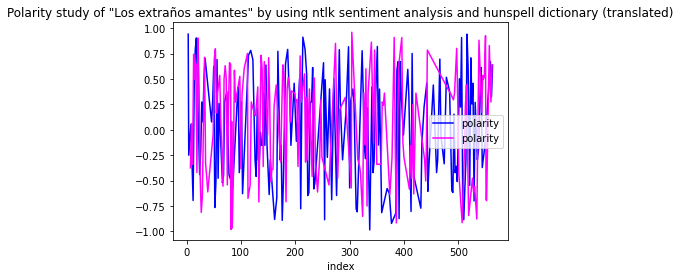

In [87]:
%matplotlib inline
plt.figure()
axis = plt.axes()
HIM.reset_index().plot(x = 'index', y = 'polarity', kind = 'line',ax = axis, color = 'blue')
HER.reset_index().plot(x = 'index', y = 'polarity', kind = 'line',ax = axis, color = 'magenta')
plt.title("Polarity study of \"Los extraños amantes\" by using ntlk sentiment analysis and hunspell dictionary (translated)")

In [88]:
NEUTRALES = df.loc[abs(df['polarity'])<1e-6]
NEUTRALES

,Personaje,Texto,text_len,word_count,TranslatedText,polarity,neg,neu,pos
0,ÉL,¡Hooop...!,14,1,¡Hooop...!,0.0,0.0,1.0,0.0
1,ELLA,¡Hooop!...,16,1,¡Hooop!...,0.0,0.0,1.0,0.0
5,ELLA,¡Aaah!... ¡chssts!.... ¡ ¿de cuánto estoy d...,53,8,Aaah!... chssts! .... How far along am I on...,0.0,0.0,1.0,0.0
6,ÉL,De viuda.,11,2,From widow.,0.0,0.0,1.0,0.0
10,ÉL,"No, si Quepede es sólo ella, por ahora; q.p.d...",178,29,"Not if Quepede is just her, for now; q.p.d. ""...",0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
554,ÉL,el corazóoon... el coooraaazóoon...,39,4,the heart... the coooraaazóoon...,0.0,0.0,1.0,0.0
555,ELLA,¡del musica-hall!...,24,2,from the music hall!....,0.0,0.0,1.0,0.0
556,ÉL,¡del music-hall!...,23,2,from the music hall!...,0.0,0.0,1.0,0.0
558,ELLA,Pero ¿dónde estoy?,20,3,But where am I?,0.0,0.0,1.0,0.0


In [86]:
for i in NEUTRALES['TranslatedText']: 
    print(i)

 ¡Hooop...!   
 ¡Hooop!...
   Aaah!... chssts! .... How far along am I on what?
 From widow.
 Not if Quepede is just her, for now; q.p.d. "May she rest in peace". Quepede.   I don't have a card but... Alvarito Sánchez of zapaterías Sánchez S.L.; and here my late wife.
 And I don't believe it.   
 If it's not a child, woman: it's a campsite.   And what about yours, was it long? I mean the marriage.
   A lot of everything, if possible; the point is to go out with my what and my everything.
   Calle!
   Silence!...
 Psst!... do you hear it?
   To whom?
 To the bell!...
 What campaign?
 La del cementerio.
 Where does it come from?
   Of course, what do you take me for?   That little thing in the middle of those big, fat diamonds.
 Impossible.
 Mi Cleo, Cleo.
   Cu-chu-cu-chu.  
 But what is this?
 Then that's all there is to it: I'll put it right now behind that cypress tree.
 That is something else.
 Let go, wolf: to another Christ with that lamp.   
   So fierce am I, then look: Eeeeh!..

Hay demasiados neutrales -> estoy analizando frases demasiado cortas, sin contexto. nltk no analiza la frase anterior o posterior a la que estas tocando, así que un mierdote. Tal vez unir varias frases seguidas concatenadas (?) Pero se pierde que sean solo de EL o ELLA,,,,,,...